# Time series forecasting
Describe a little

## Setup

In [874]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# This is because I use VSCode with a dark theme which makes the axes labels from plots unreadable
mpl.style.use('dark_background')

## The dataset
Describe...

In [1001]:
df = pd.read_excel('https://raw.githubusercontent.com/jrnkng/KLM_Analytics_Challenge/main/RSM_KLM_StudentChallenge_Challenge1_RawData.xlsx')

### Inspect and cleanup

In [1002]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CA_Count_Ratio,1857.0,8.554527,2.295318,6.097240,7.375370,8.115620,8.715934,25.898919
CA_FTE_Ratio,1857.0,8.458395,2.301139,5.720715,7.260869,8.002393,8.595963,25.414552
CA_Count,1857.0,336.263328,79.110036,232.000000,303.000000,320.000000,342.000000,1030.000000
CA_FTE,1857.0,260.432983,61.878214,171.360000,232.740000,247.620000,265.910000,800.810000


For now, we are only concerned with the CA_Count_Ratio

In [1004]:
df = df[['CA_Count_Ratio']][:1100]

<AxesSubplot:>

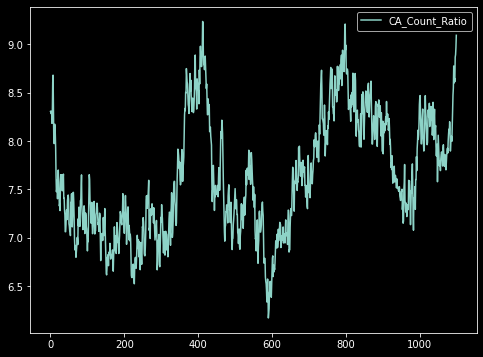

In [1005]:
df.plot()

Data remains relatively stable, with some major peaks and drops (further inspect). To improve the quality for forecasting, the data will be made more stationary by differencing.

In [968]:
df = df.diff()
df = df[1:] # Remove first NaN row

<AxesSubplot:>

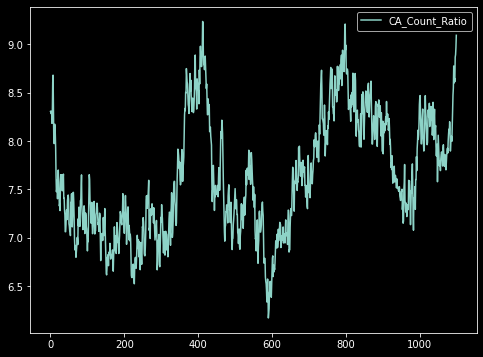

In [1006]:
df.plot()

### Split the data
We use a 75, 25 split for the training, validation and test tests. TODO: Add val later on

In [1007]:
column_indices = {name: i for i, name in enumerate(df.columns)}



df_len = len(df)
train_size = 0.75
val_size = 0.15
test_size = 0.10

train_df = df[0:int(df_len * train_size)]
val_df = df[int(df_len * train_size): int(df_len * (1-test_size))]
test_df = df[int(df_len * (1-test_size)):]

n_features = df.shape[1]

## Scale the data

Fit the scaler on only the training data to avoid leakage

In [1008]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
# TODO: Try different one

In [1009]:
train_df[['CA_Count_Ratio']] = min_max_scaler.fit_transform(train_df[['CA_Count_Ratio']])
val_df[['CA_Count_Ratio']] = min_max_scaler.transform(val_df[['CA_Count_Ratio']])
test_df[['CA_Count_Ratio']] = min_max_scaler.transform(test_df[['CA_Count_Ratio']])

/var/folders/fv/xqy70s890_l76rwgdkbvl_tw0000gn/T/ipykernel_48217/3083613642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[['CA_Count_Ratio']] = min_max_scaler.fit_transform(train_df[['CA_Count_Ratio']])
/var/folders/fv/xqy70s890_l76rwgdkbvl_tw0000gn/T/ipykernel_48217/3083613642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[['CA_Count_Ratio']] = min_max_scaler.transform(val_df[['CA_Count_Ratio']])
/var/folders/fv/xqy70s890_l76rwgdkbvl_tw0000gn/T/ipykernel_48217/3083613642.py:3: Se

<AxesSubplot:title={'center':'Test'}>

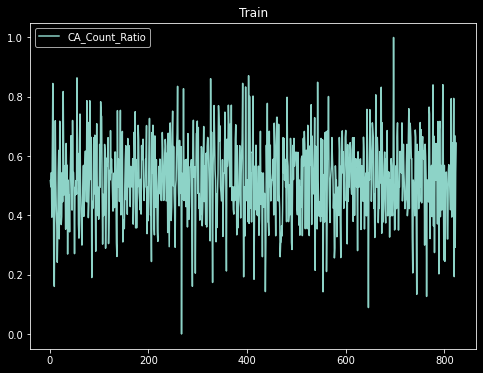

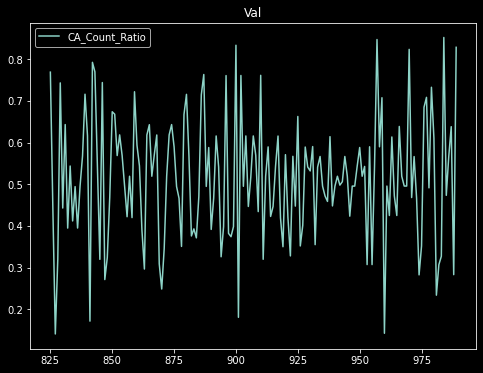

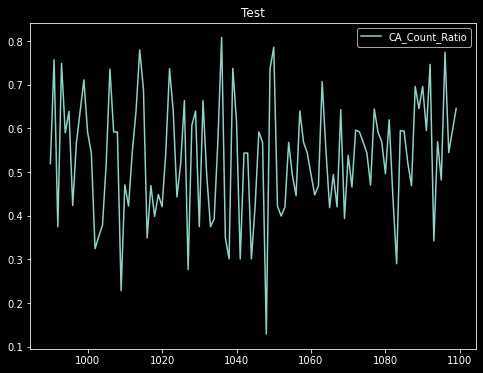

In [973]:
train_df.plot(title='Train')
val_df.plot(title='Val')
test_df.plot(title='Test')

## Data windowing
We will make predictions based on a window of consecutive samples from the data.
Start by making a `WindowGenerator` class, which implements an interface that can:
1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

In [1010]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df = val_df, test_df=test_df,
    label_columns=['CA_Count_Ratio']):
        # Store the data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                enumerate(label_columns)}

        self.column_indices = {name: i for i, name in
            enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])



In [1011]:
w2 = WindowGenerator(6, 1, 1)

### 2. Split
Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [1012]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [1013]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1)

In [1014]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


Good note:
The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot
Visualizing the split window

In [1015]:
w2.example = example_inputs, example_labels

In [1016]:
def plot(self, model=None, plot_col='CA_Count_Ratio', max_subplots=5):
  
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs, training=True)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

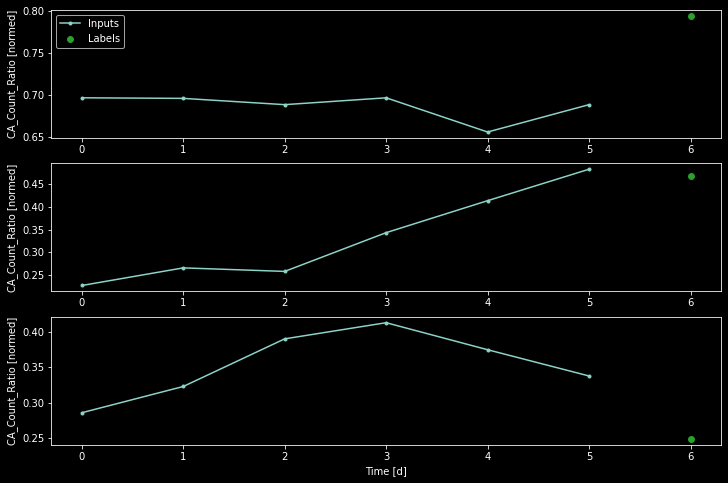

In [1017]:
w2.plot()

### 4. Create tensorflow datasets
This `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [1018]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=128,) # Prev 32

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [1019]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

# TODO: Remove
@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [1020]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

## Single step models
Predicting the absence one step ahead:

We are going to be testing multiple models, so we will package the training procedure into a `compile and fit` function

In [1021]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [1022]:
val_performance = {}
performance = {}

### Multi-step input
Instead of feeding the model a single time-step, we will provide it with multiple previous timesteps to give it context

In [1023]:
CONV_WIDTH =  14
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1
)
conv_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['CA_Count_Ratio']

### Multi-step dense

In [1024]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, ),
    tf.keras.layers.Dense(units=32, ),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [1025]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

2/2 [==============================] - 0s 1ms/step - loss: 0.0031 - mean_absolute_error: 0.0446


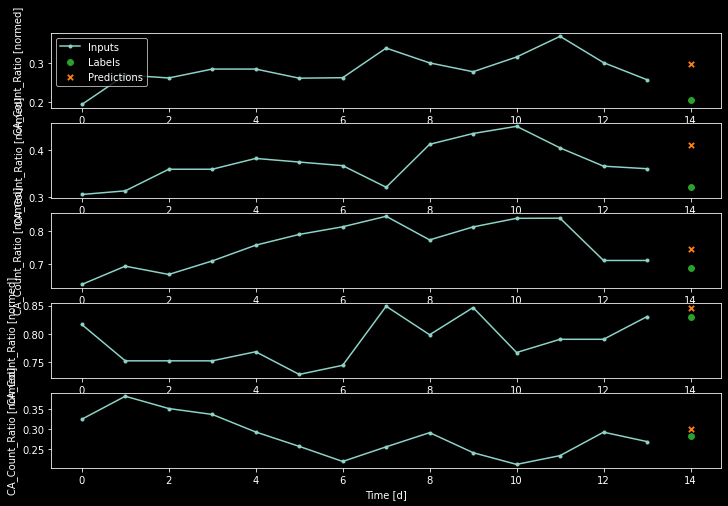

In [1026]:
conv_window.plot(multi_step_dense)
# TODO: Check everything about this model! Why does it nuot just predict averages?

## Multi-step forecasting models

In [1027]:
multi_val_performance = {}
multi_performance = {}

In [1028]:
OUT_STEPS = 12

multi_window = WindowGenerator(input_width=24,
    label_width = OUT_STEPS,
    shift = OUT_STEPS
)

## RNN

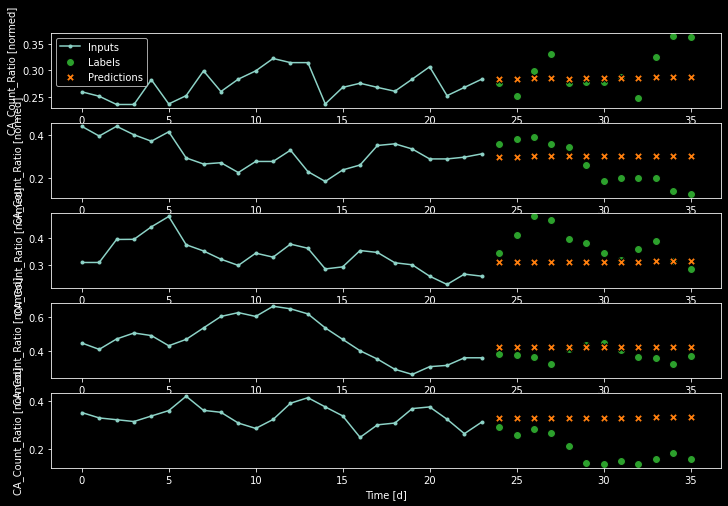

In [1029]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*n_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])
history = compile_and_fit(multi_lstm_model, multi_window)
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

multi_window.plot(multi_lstm_model)
IPython.display.clear_output()